# Unravelling the complex interplay between climate as well as environmental drivers and conflict


This notebook contains the most recent workflow and outputs of the underlying machine-learning model.

**Note:** This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

For information about the model, the underlying code, and how to install and execute it, we refer to the online documentation [still missing].

For questions, please contact J.M. Hoch (j.m.hoch@uu.nl).

With contributions from N. Wanders (Utrecht University) and S. de Bruin (PBL).

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, neighbors, naive_bayes, preprocessing, model_selection, metrics, utils
import os, sys
import warnings

In [2]:
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [3]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.4b1
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [5]:
config, out_dir = conflict_model.utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP\ged201-csv.zip



# Filter conflicts

As conflict database, we use the [PRIO/UCDP database](https://ucdp.uu.se/downloads/). Not all conflicts of the database may need to be used in the model. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is simply not in our area-of-interest.

In the selection procedure, we first load the conflict database and convert it to a georeferenced dataframe (geo-dataframe). We then only keep those entries that fit to our selection criteria as specified in the cfg-file. Subsequently, we clip the remaining conflict datapoints to the extent of a provided shp-file, representing the area-of-interest. Here, we focus on the African continent and do the analysis at the scale of water provinces. The remaining conflict points are then used for the machine-learning model.

In [6]:
conflict_gdf, extent_gdf, extent_active_polys_gdf, global_df = conflict_model.selection.select(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP\ged201.csv

translating to geopandas dataframe

filtering on conflict properties...
...filtering key best with lower value 1
...filtering key type_of_violence with value(s) ['1', '2', '3']
focussing on period between 2000 and 2015
reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp

fixing invalid geometries

clipping clipping conflict dataset to extent



Depending on the settings, we may focus on some climate zones only. As such, not all water provinces are used in the model. For a visual inspection if this selection worked as intended, we plot below the conflicts and as background map only those water provinces that are actually used in the model.

In case climate zones are specified, the number of active polygons should be less than the number of all polygons. If not climate zones are specified, both plots should be identical.

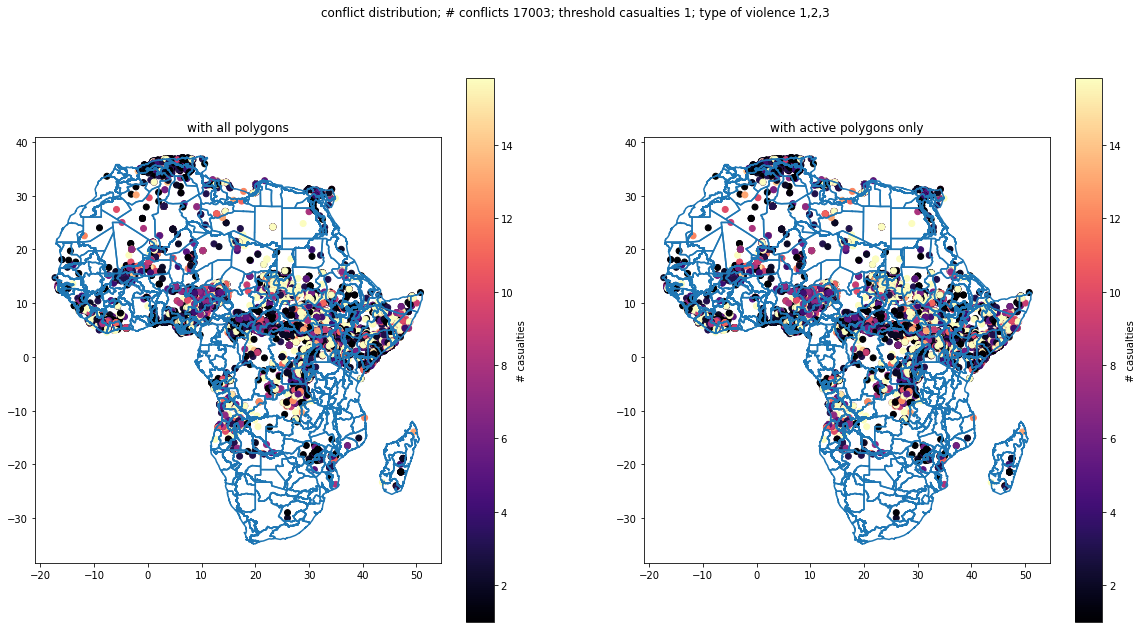

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('conflict distribution; # conflicts {}; threshold casualties {}; type of violence {}'.format(len(conflict_gdf), config.get('conflict', 'min_nr_casualties'), config.get('conflict', 'type_of_violence')))

conflict_gdf.plot(ax=ax1, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_gdf.boundary.plot(ax=ax1)
ax1.set_title('with all polygons')

conflict_gdf.plot(ax=ax2, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_active_polys_gdf.boundary.plot(ax=ax2)
ax2.set_title('with active polygons only')
                         
plt.savefig(os.path.join(out_dir, 'conflict_and_casualties_distribution.png'), dpi=300)

# Get the data

This is an essential part of the code. Here, we go through all model years as specified in the cfg-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit (here water province) or not;
2. Loop through various files with climate or environmental variables, and get mean variable value per geographical unit (here water province).

This information is stored in two different arrays. The X-array represents all climate/environmental variable values per polygon per year, while the Y-array represents the binary classifier whether conflict took place or not. In case some variables did contain no data for a given water province, this data points is dropped entirely.

Because the reading and processing of the data can be quite time-consuming (depending on number of files and simulation period), it is also possible to specify in the cfg-file a npy-file containing the concatenated XY-data. The XY-data will then be read directly and no data reading and processing is needed.

In [8]:
# %%capture

X, Y = conflict_model.pipeline.create_XY(config, conflict_gdf, extent_active_polys_gdf)

loading XY data from file C:\Users\hoch0001\Documents\_code\conflict_model\data\XY.npy

number of data points including missing values: 5790
number of data points excluding missing values: 5760
from this, 1216 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 21.11 percent.


# Machine Learning

## Data scaling and model algorithm

Before we can get started, we have define the data scaling technique of choice and the machine-learning algorithm to be applied.

#### Scaler

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

The scaler is then used to fit the X-data and transform it according to scaler-specific method. Y-data is not scaled since it is either 0 or 1 already.

### Models

The variety of ML models is sheer endless. The model provides three models for supervised learning which showed better performance than other candidates in previous assessment rounds. Also, all model parameters were already calibrated using GridSearchCV in previous analyses.

In [21]:
scaler, clf = conflict_model.pipeline.prepare_ML(config)

chosen scaling method is [QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)]
chosen ML model is [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')]


## Model initialization

Before the model can be executed, some variables need to be initialized.

First, some dataframes to contain the X and Y data of the test samples per model execution, since the training and prediction step should ideally be performed more than once. Also, a sub-set of the data where only those data points with observed conflict are stored (indicated by the 1).

In [22]:
out_X_df = conflict_model.evaluation.init_out_df()
out_X1_df = conflict_model.evaluation.init_out_df()
out_y_df = conflict_model.evaluation.init_out_df()
out_y1_df = conflict_model.evaluation.init_out_df()

Second, a dictionary in which we store the computed model evaluation scores per model execution. Currently, the evaluatoin scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets;

In [23]:
out_dict = conflict_model.evaluation.init_out_dict()

Third, some variables needed to plot the ROC (Receiver Operating Characteristic) [curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) and [score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) per model execution and after all executions the mean ROC curve.

In [24]:
trps, aucs, mean_fpr = conflict_model.evaluation.init_out_ROC_curve()

## Model execution

Now it's time for the real deal! All modelling steps are hidden away in the pipeline.run function, everything else is needed for processing model output.

Per n model execution, three variables are returned:

1. *X_df*: a dataframe containing the variable values for the test samples;
2. *y_df*: a dataframe containing not only the binary classifier of the test samples, but also the geometry of the associated water provinces as well as the model prediction;
3. *eval_dict*: a dictionary containing the scores of above-described evaluation metrics.

These outputs may be further processed (e.g. by selecting only datapoints with conflict=1) and are appended for each n model execution.

Also, the ROC curve per n model execution is plotted, and after all model execution the mean ROC curve is added.

In [25]:
%%capture

#- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config.getint('settings', 'n_runs')):
    
    if config.getboolean('general', 'verbose'):
        print('run {} of {}'.format(n+1, config.getint('settings', 'n_runs')) + os.linesep)

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = conflict_model.pipeline.run(X, Y, config, scaler, clf, out_dir)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = conflict_model.utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = conflict_model.evaluation.fill_out_df(out_X_df, X_df)
    out_X1_df = conflict_model.evaluation.fill_out_df(out_X1_df, X1_df)
    out_y_df = conflict_model.evaluation.fill_out_df(out_y_df, y_df)
    out_y1_df = conflict_model.evaluation.fill_out_df(out_y1_df, y1_df)
    out_dict = conflict_model.evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = conflict_model.evaluation.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
conflict_model.evaluation.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)
#- save plot
plt.savefig(os.path.join(out_dir, 'ROC_curve_per_run.png'), dpi=300)

## Model evaluation

It is now possible to determin ethe average score of the evaluation criteria. Additionally, the distribution of the values per metric can be visualized.

In [26]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 50 repetitions is 0.868
average Precision of run with 50 repetitions is 0.729
average Recall of run with 50 repetitions is 0.605
average F1 score of run with 50 repetitions is 0.661
average Cohen-Kappa score of run with 50 repetitions is 0.580
average Brier loss score of run with 50 repetitions is 0.094
average ROC AUC score of run with 50 repetitions is 0.902


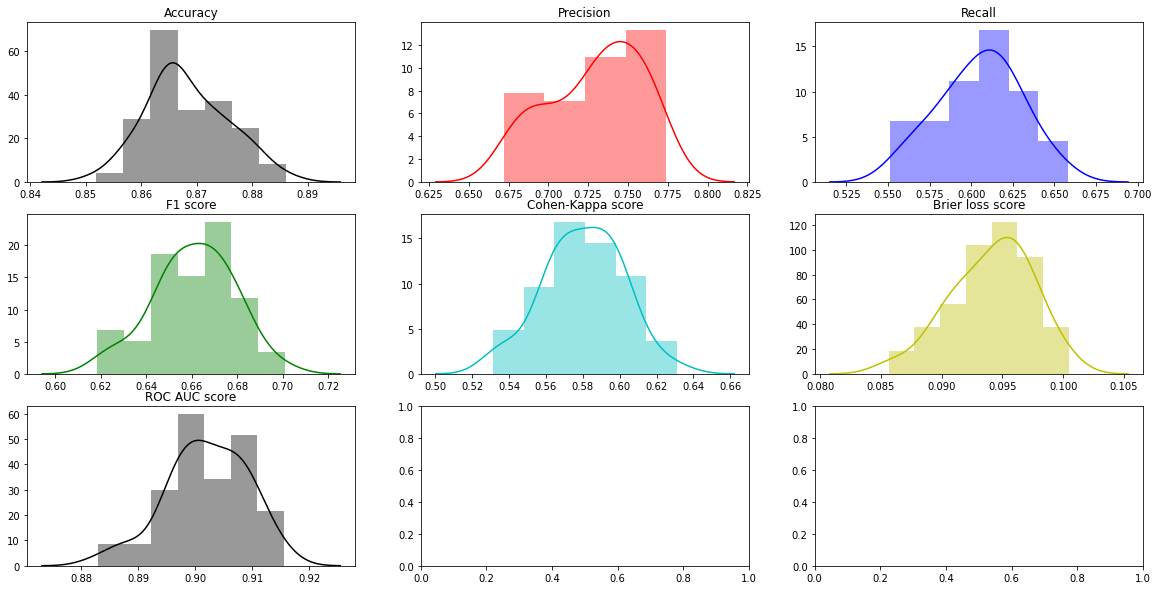

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
sbs.distplot(out_dict['Accuracy'], ax=axes[0,0], color="k")
axes[0,0].set_title('Accuracy')
sbs.distplot(out_dict['Precision'], ax=axes[0,1], color="r")
axes[0,1].set_title('Precision')
sbs.distplot(out_dict['Recall'], ax=axes[0,2], color="b")
axes[0,2].set_title('Recall')
sbs.distplot(out_dict['F1 score'], ax=axes[1,0], color="g")
axes[1,0].set_title('F1 score')
sbs.distplot(out_dict['Cohen-Kappa score'], ax=axes[1,1], color="c")
axes[1,1].set_title('Cohen-Kappa score')
sbs.distplot(out_dict['Brier loss score'], ax=axes[1,2], color="y")
axes[1,2].set_title('Brier loss score')
sbs.distplot(out_dict['ROC AUC score'], ax=axes[2,0], color="k")
axes[2,0].set_title('ROC AUC score')
plt.savefig(os.path.join(out_dir, 'distribution_output_evaluation_criteria.png'), dpi=300);

Futhermore, the ROC curve as well as the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [precision-recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) can be plotted based on all test samples. Not sure though if this is really meaningful since ROC-AUC score and AP score are very good...

* Confusion matrix: evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class;
* Precision-recall curve: computes a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold.

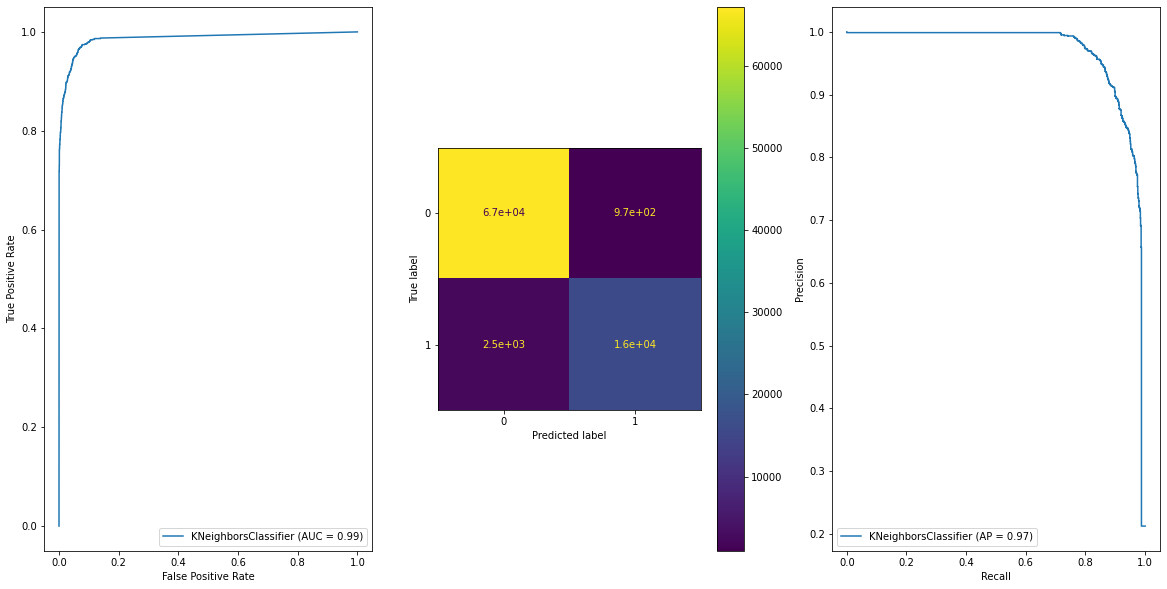

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
metrics.plot_roc_curve(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax1)
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax2)
metrics.plot_precision_recall_curve(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax3)
plt.savefig(os.path.join(out_dir, 'evaluation_plots_all_data.png'), dpi=300);

Thus far, we merely looked at numerical scores. This of course tells us a lot about the quality of the machine-learning model and its predictions, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model output can be connected to its polygon using a unique ID.

In [29]:
df_hit, gdf_hit = conflict_model.evaluation.get_average_hit(out_y_df, global_df)

In [30]:
df_hit_1, gdf_hit_1 = conflict_model.evaluation.get_average_hit(out_y1_df, global_df)

First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

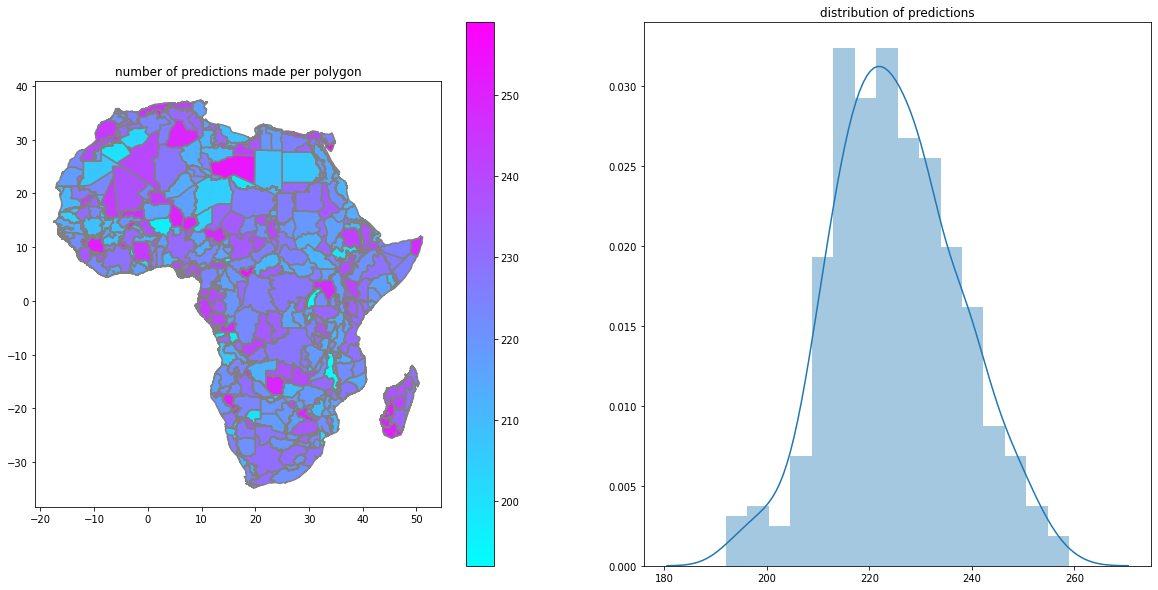

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions')
plt.savefig(os.path.join(out_dir, 'analyis_predictions.png'), dpi=300);

Similarly, we can do this with the data points containing only those entries related to observed conflict. We see that the spread of predictions made per polygon is much larger than when considering all data points.

For those polygons in white no conflict was ever observed in all test samples, i.e. for those polygons no conflicts are reported in the conflict database with very high likeliness.

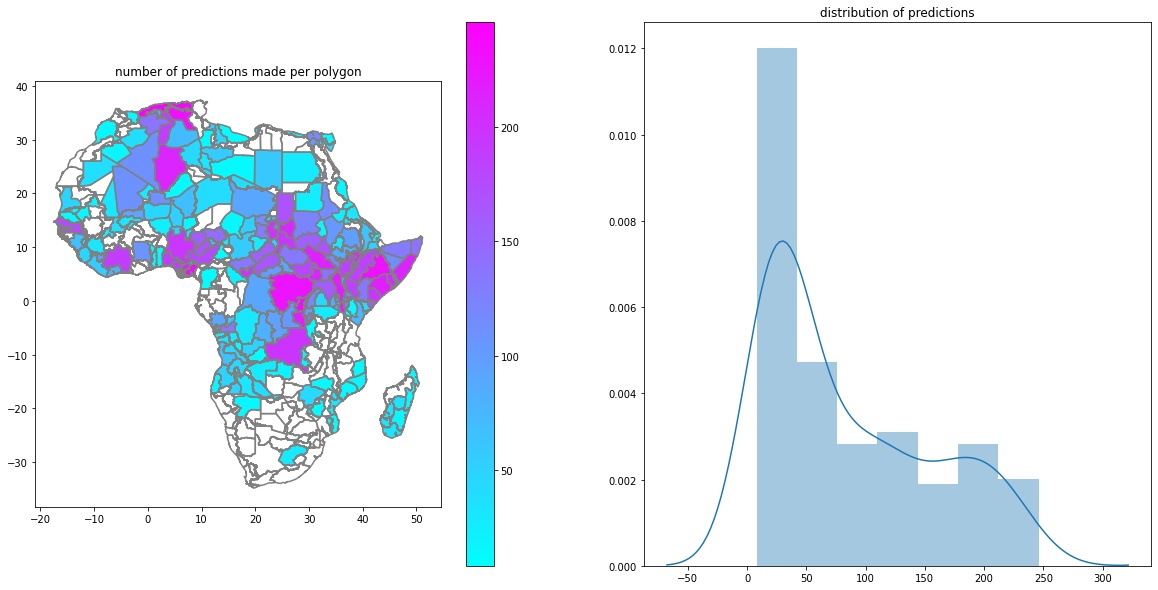

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit_1.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit_1.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions')
plt.savefig(os.path.join(out_dir, 'analyis_predictions_conflict_only.png'), dpi=300);

By repeating the model n times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis.

In [33]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(extent_active_polys_gdf)*100))

99.48 % of all active polygons are considered in test sample


Moreover, we can analyse how often the model makes a correct prediciont of conflict or non-conflict per polygon. By comparing this skill with the overall number of conflicts per polygon, this may lead to additional insights.

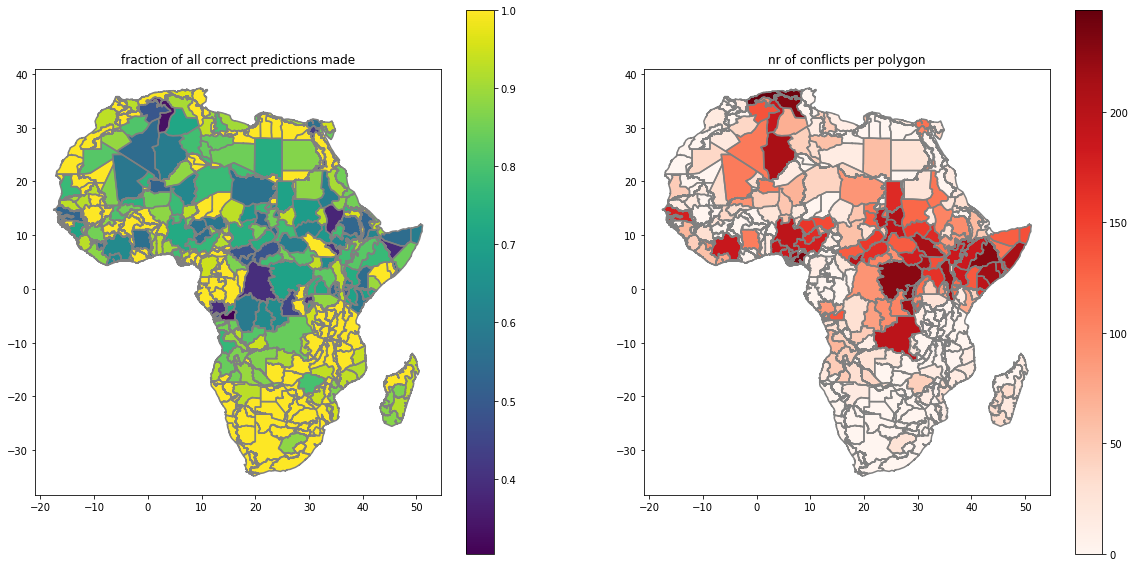

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='average_hit', legend=True, figsize=(20,10))
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('fraction of all correct predictions made')
gdf_hit.plot(ax=ax2, column='nr_of_test_confl', legend=True, cmap='Reds')
extent_active_polys_gdf.boundary.plot(ax=ax2, color='0.5')
ax2.set_title('nr of conflicts per polygon')
plt.savefig(os.path.join(out_dir, 'average_hit_precision.png'), dpi=300);

Again, we repeat this with the sub-set of conflict-only data. At a first glance, results may indicate that the number of conflicts observed in a polygon is a strong predictor how accurate the model predicts conflict. While this is surely an important model-related driver, other factors may play a role too.

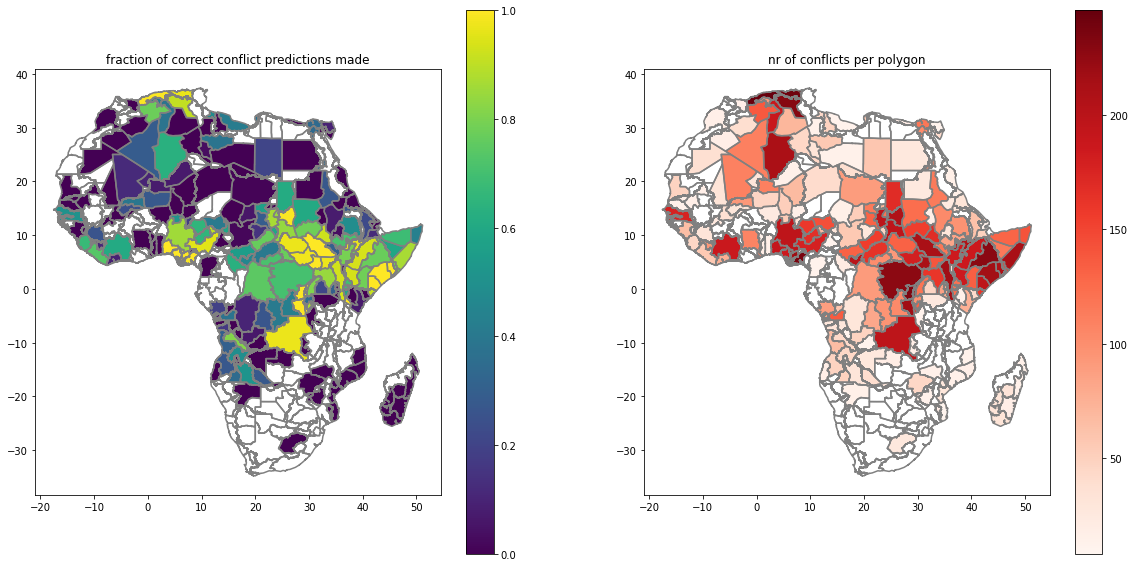

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit_1.plot(ax=ax1, column='average_hit', legend=True, figsize=(20,10))
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('fraction of correct conflict predictions made')
gdf_hit_1.plot(ax=ax2, column='nr_of_test_confl', legend=True, cmap='Reds')
extent_active_polys_gdf.boundary.plot(ax=ax2, color='0.5')
ax2.set_title('nr of conflicts per polygon')
plt.savefig(os.path.join(out_dir, 'average_hit_precision_conflicts_only.png'), dpi=300);

Last, we can check how the distribution of correct predictions changes between considering all predictions (i.e. both conflict and non-conflict) and conflict-only predictions.

While for the first the average hit ratio per polygon is clearly oriented towards 1 (i.e. only correct predictions), the distribution looks very different for the latter...

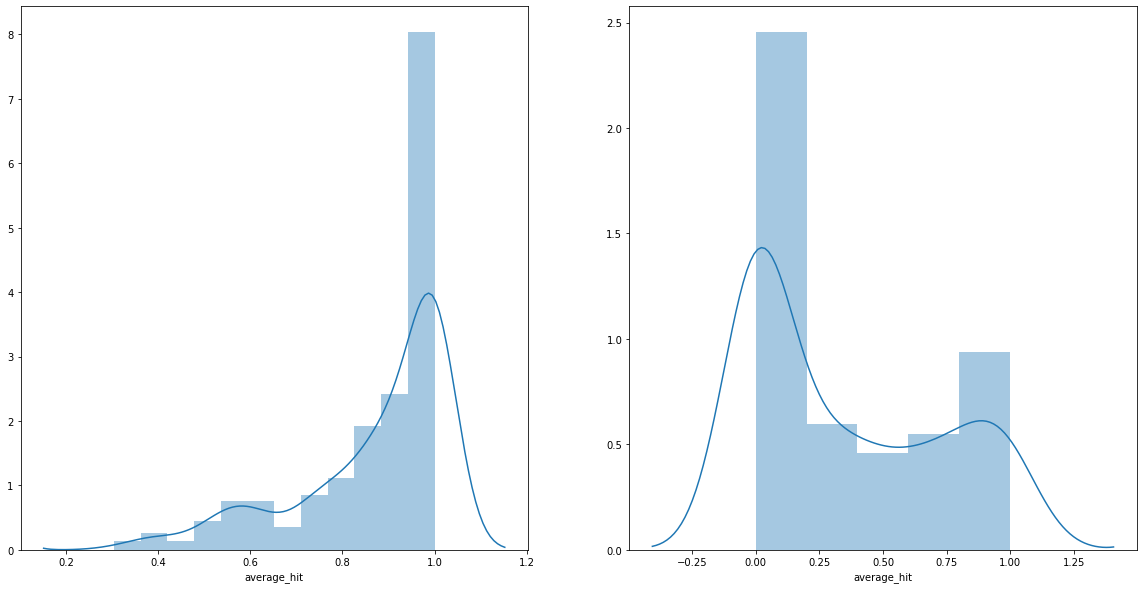

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sbs.distplot(gdf_hit.average_hit, ax=ax1)
sbs.distplot(gdf_hit_1.average_hit, ax=ax2)
plt.savefig(os.path.join(out_dir, 'distribution_average_hit.png'), dpi=300);

To understand to what extent the model accuracy (i.e. hits) may depend on the number of predictions made per polygon or other factors, we plot some simple scatter plots.

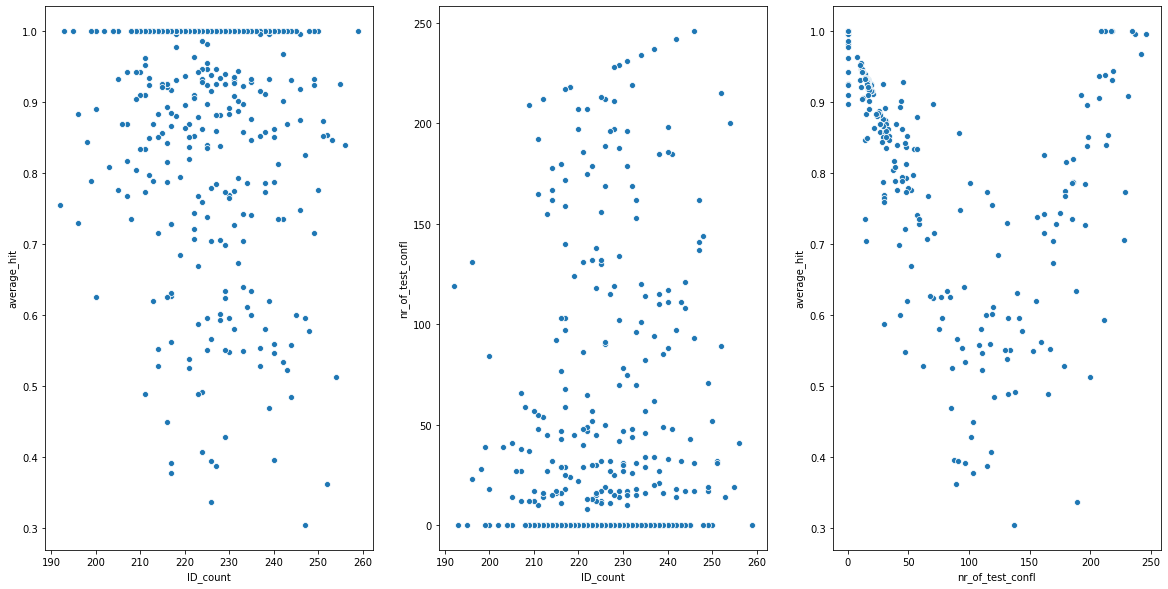

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
sbs.scatterplot(data=df_hit, x='ID_count', y='average_hit', ax=ax1)
sbs.scatterplot(data=df_hit, x='ID_count', y='nr_of_test_confl', ax=ax2)
sbs.scatterplot(data=df_hit, x='nr_of_test_confl', y='average_hit', ax=ax3)
plt.savefig(os.path.join(out_dir, 'scatterplot_analysis'), dpi=300)

It is clear that the average accuracy is strongly controlled by the overall number of correct predictions, should be no surpose. We furthermore see that the average accuracy does not depend on the number of predictions made. Last, it shows that the average hit is better if a certain threshold of conflicts observations are made in a polygon. And of course if there are only very little conflicts, because the model then needs to predict non-conflicts which works better anyway.

We may also express this with a correlation matrix. This again shows that there is hardly any correlation between factors except for total hits and average hit accuracy.

In [38]:
df_corr = df_hit.drop('geometry', axis=1)
df_corr = df_corr.corr()

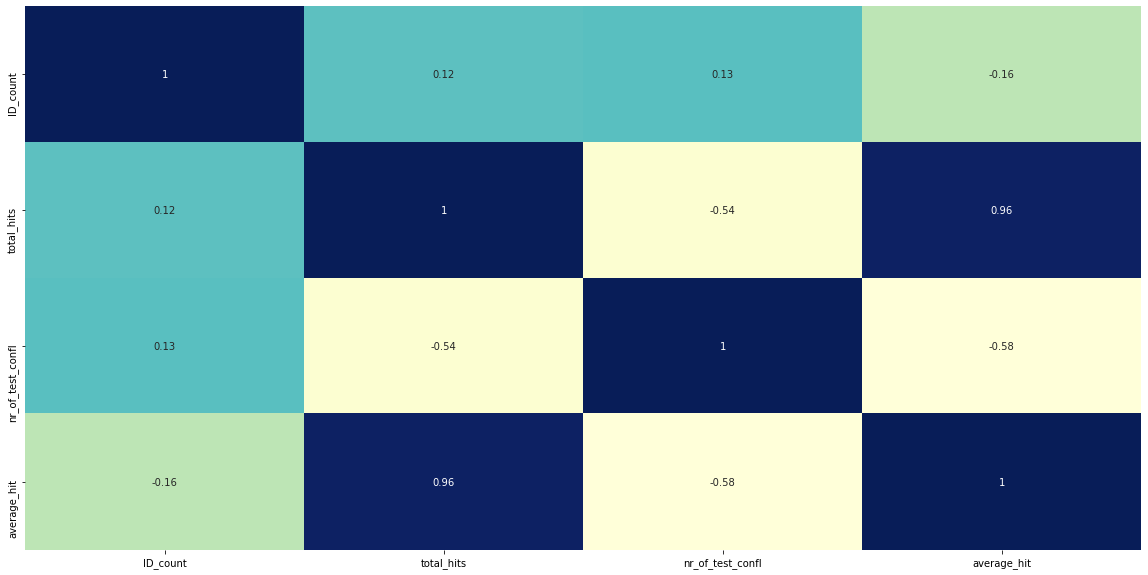

In [39]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
sbs.heatmap(df_corr, cmap='YlGnBu', annot=True, cbar=False, ax=ax1)
plt.savefig(os.path.join(out_dir, 'correlation_matrix.png'), dpi=300)

Up to know, we looked at two or more indicators of how the model performed and other statistical analyses per polygon. It's now time to come up with an indicator for which polygons we 'trust' the model.

Thus, we compute the median of the average hit accuracy of all polygons. This allows for dividing the polygons in the 50 % with an average hit accuracy above the median, and the other 50 % below it. These are our main categories:

* 'H': upper 50 % of average hit accuracy;
* 'L': lower 50 % of average hit accuracy.

In addition, we may want to know how this categorization depends on the number of conflicts in a polygon. For example, wich polygons have a high accuracy with lots of conflicts? For these polygons, we could assume that the model robustly succeeds in predicting conflict. To that end, we also compute the median number of conflicts per polygon.

This yields four sub-categories:

* 'HH': upper 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'HL': upper 50 % of average hit accuracy, but then with lower 50 % of number of conflicts;
* 'LH': lower 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'LL': lower 50 % of average hit accuracy, but then with lower 50 % of number of conflicts.

In [91]:
average_hit_median = df_hit.average_hit.median()
nr_confl_median = df_hit.nr_of_test_confl.median()

In [92]:
gdf_hit['main_category'] = ''
gdf_hit['sub_category'] = ''

In [102]:
gdf_hit['main_category'].loc[gdf_hit.average_hit >= average_hit_median] = 'H'
gdf_hit['main_category'].loc[gdf_hit.average_hit < average_hit_median] = 'L'

In [103]:
gdf_hit['sub_category'].loc[(gdf_hit.average_hit >= average_hit_median) & 
                       (gdf_hit.nr_of_test_confl >= nr_confl_median)] = 'HH'
gdf_hit['sub_category'].loc[(gdf_hit.average_hit >= average_hit_median) & 
                       (gdf_hit.nr_of_test_confl < nr_confl_median)] = 'HL'
gdf_hit['sub_category'].loc[(gdf_hit.average_hit < average_hit_median) & 
                       (gdf_hit.nr_of_test_confl >= nr_confl_median)] = 'LH'
gdf_hit['sub_category'].loc[(gdf_hit.average_hit < average_hit_median) & 
                       (gdf_hit.nr_of_test_confl < nr_confl_median)] = 'LL'

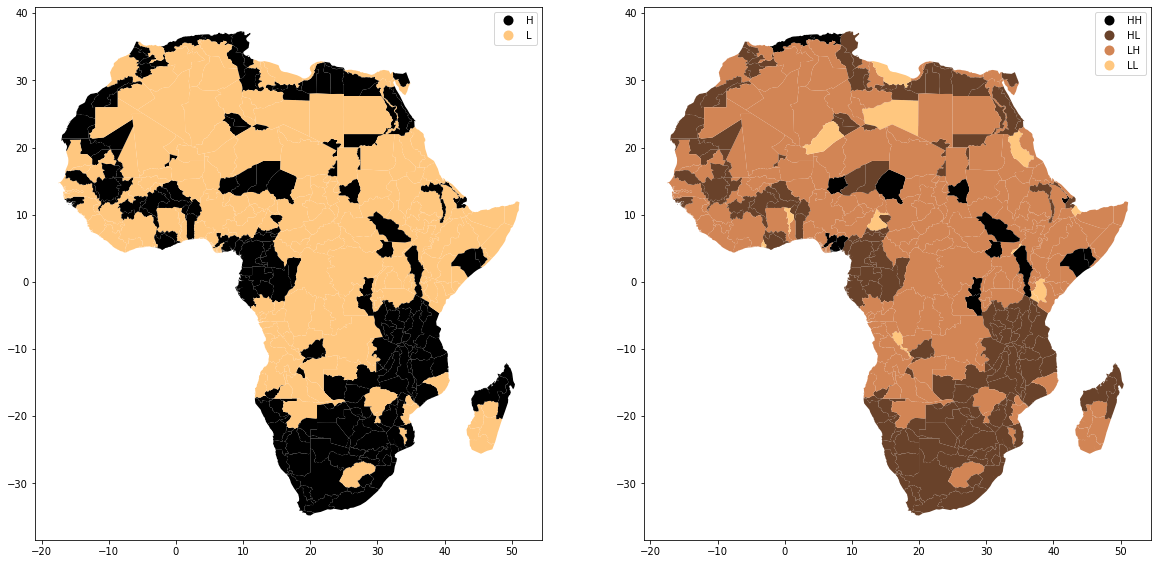

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(column='main_category', categorical=True, legend=True, ax=ax1, cmap='copper')
gdf_hit.plot(column='sub_category', categorical=True, legend=True, ax=ax2, cmap='copper')